In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.svm import LinearSVC

In [21]:
session = "Pilot5"
data_dir = f"/Users/thenning/Documents/GitHub/neurobubbles/Data/{session}"
order_data = pd.read_csv((glob.glob(f"{data_dir}/orders*.csv"))[0])
round_data = pd.read_csv((glob.glob(f"{data_dir}/rounds*.csv"))[0])
payments_data = pd.read_csv((glob.glob(f"{data_dir}/payment*.csv"))[0])
prescreen_data = pd.read_csv((glob.glob(f"{data_dir}/prescreen*.csv"))[0])
pagetime_data = pd.read_csv((glob.glob(f"{data_dir}/PageTimes*.csv"))[0])


# Price Data

In [22]:
def basic_price_data(order_data):
    sell_orders = []
    min_sell_price = []
    buy_orders = []
    max_buy_price = []
    market_price = []
    volume = []
    for round in np.unique(order_data['round_number']):
        df = order_data[order_data['round_number']== round]
        sell_orders.append(np.sum(df[df['type'] == 'SELL']['quantity']))
        min_sell_price.append(np.min(df[df['type'] == 'SELL']['price']))
        buy_orders.append(np.sum(df[df['type'] == 'BUY']['quantity']))
        max_buy_price.append(np.max(df[df['type'] == 'BUY']['price']))
        market_price.append(np.unique(df['market_price']))
        volume.append(np.unique(df['volume']))


    #turning into numpy arrays cause its nice
    sell_orders_array = np.array(sell_orders)
    min_sell_price_array = np.array(min_sell_price)
    buy_orders_array = np.array(buy_orders)
    max_buy_price_array = np.array(max_buy_price)
    market_price_array = np.array(market_price)
    volume_array = np.array(volume)
    return sell_orders_array, min_sell_price_array, buy_orders_array, max_buy_price_array,market_price_array, volume_array

sell_orders_array, min_sell_price_array, buy_orders_array, max_buy_price_array,market_price_array, volume_array = basic_price_data(order_data)

# Risk Adjusted Moving Average

In [23]:
def get_round_risk_adjusted(round_data):
    risk_adjusted_score=[]
    for i in np.unique(round_data['subsession.round_number']):
        if i <= 3:
            risk_adjusted_score.append(None)
        else:
            r1 = round_data[round_data['subsession.round_number'] == i]
            risk_adjusted_score.append(np.mean(r1["player.dose_r"]))
    return risk_adjusted_score
risk_adjusted_score = get_round_risk_adjusted(round_data)

def get_risk_adj_mv_avg(round_data, m):
    risk_adjusted_score = get_round_risk_adjusted(round_data)
    mv_avg = []
    for idx, score in enumerate(risk_adjusted_score):
        if idx < 3: # makes sure not in practice
            continue
        else:
            scores = []
            if idx - m < 3: # if moving average would go into practice then cut avg short
                if idx - 3 == 0: #fixes 0 case
                    scores.append(risk_adjusted_score[idx])
                else:
                    for i in range(idx - 3):
                        scores.append(risk_adjusted_score[idx - i])
            else:
                for i in range(idx - m):
                    scores.append(risk_adjusted_score[idx - i])
            mv_avg.append(np.mean(scores))
    return mv_avg

risk_adjusted_score = get_risk_adj_mv_avg(round_data, 3)

# Forecast Error

Text(0.5, 1.0, 'Forecast Error 10-period')

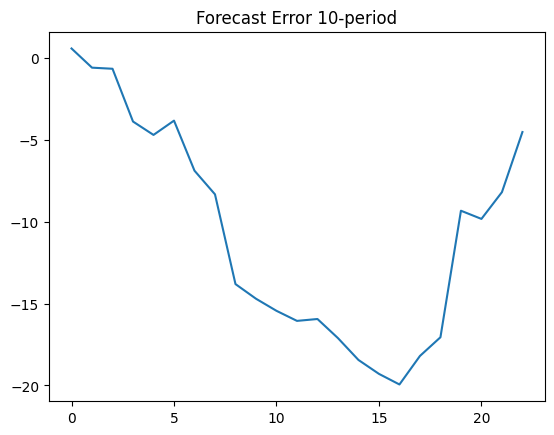

In [24]:
def get_forecast_data(round_data):
    f1mean_forecast=[]
    f2mean_forecast=[]
    f3mean_forecast=[]
    f4mean_forecast=[]
    for i in np.unique(round_data['subsession.round_number']):
        r1 = round_data[round_data['subsession.round_number'] == i]
        f1mean_forecast.append(np.mean(r1['player.f0']))
        f2mean_forecast.append(np.mean(r1['player.f1']))
        f3mean_forecast.append(np.mean(r1['player.f2']))
        f4mean_forecast.append(np.mean(r1['player.f3']))
    return [f1mean_forecast, f2mean_forecast, f3mean_forecast, f4mean_forecast]

def forecast_error(round_data,market_price_array, t, m):
    forecasts = get_forecast_data(round_data)
    if m == 0:
        forecast_array = forecasts[0]
    elif m == 2:
        forecast_array = forecasts[1]
    elif m == 5:
        forecast_array = forecasts[2]
    elif m == 10:
        forecast_array = forecasts[3]

    forecast_error = forecast_array[t-m] - market_price_array[t]
    return forecast_error[0]

def generate_forecast_error(round_data, market_price_array, m):
    forecast_error_array = []
    for t, price in enumerate(market_price_array):
        if t < m:
            error = None
        else:
            error = forecast_error(round_data, market_price_array, t, m)
        forecast_error_array.append(error)
    return forecast_error_array

m = 10
errors = generate_forecast_error(round_data, market_price_array, m)
plt.plot(errors[m:])
plt.title(f"Forecast Error {m}-period")


# Orderbook Pressure

In [25]:
def get_orderbook_pressure_per_round(order_data, t):
    round_data = order_data[order_data['round_number']== t]
    market_price = np.unique(round_data['market_price'])[0]

    buy_d = round_data[round_data['type'] =='BUY']
    max_unfilled_bid = np.max(buy_d[buy_d['price'] <market_price]['price'])
    bid_quantity = np.sum(buy_d[buy_d['price'] ==max_unfilled_bid]['quantity'])

    ask_d = round_data[round_data['type'] =='SELL']
    min_unfilled_ask = np.min(ask_d[ask_d['price'] > market_price]['price'])
    ask_quantity = np.sum(ask_d[ask_d['price'] ==min_unfilled_ask]['quantity'])

    obook_pressure = (max_unfilled_bid * bid_quantity + min_unfilled_ask * ask_quantity)/(bid_quantity+ask_quantity)
    return obook_pressure

def get_order_book_ressure(order_data ):
    order_book_pressure = []
    for round in np.unique(order_data['round_number']):
        order_book_pressure.append(get_orderbook_pressure_per_round(order_data, round))
    return (order_book_pressure)
order_book_pressure = get_order_book_ressure(order_data)

# Asset Allocation

In [26]:
def get_asset_allocation(round_data):
    allocation_list = []
    for i in np.unique(round_data['subsession.round_number']):
        r1 = round_data[round_data['subsession.round_number'] == i]
        cash = np.sum(r1['player.cash'])
        shares = np.sum(r1['player.shares'])
        if i == 4:
            price = 14
        else:
            price = market_price_array[i-2] # -1 since idx starts at 1, -1 for lag
        market_cap = shares * price
        allocation = cash.item() / market_cap.item()
        allocation_list.append(allocation)
    return allocation_list
allocation_list = get_asset_allocation(round_data)
len(allocation_list)

33

# Round Level analysis

In [28]:
round_ml_data = {
    'price': [],
    'volume': [],
    'lag_price': [],
    'lag_volume': [],
    'price_change': [],
    'period-1 forecast error': [],
    'period-3 forecast error': [],
    'period-6 forecast error': [],
    'period-11 forecast error': [],
    'laged_risk_parameter_mv_avg': [],
    'rounds_remaining': [],
    'order_book_pressure': [],
    'asset_allocation': []
}

# Populate the lists with values for each round
for round in np.unique(order_data['round_number']):
    if round > 3:
        round_ml_data['price'].append(market_price_array[round-1][0])
        round_ml_data['volume'].append(market_price_array[round-1][0])
        if round == 4:
            round_ml_data['price_change'].append(market_price_array[round-1][0] - 14)
            round_ml_data['lag_price'].append(14)
            round_ml_data['lag_volume'].append(None)
            round_ml_data[f'laged_risk_parameter_mv_avg'].append(None)
        else:
            round_ml_data['price_change'].append(market_price_array[round-1][0] - market_price_array[round-2][0])
            round_ml_data['lag_price'].append(market_price_array[round-2][0])
            round_ml_data['lag_volume'].append(volume_array[round-2][0])
            round_ml_data[f'laged_risk_parameter_mv_avg'].append(risk_adjusted_score[round - 3 - 2]) # -3 since it doesn't include practice, -1 since round index starts at 1, -1 for lagged
        round_ml_data['rounds_remaining'].append(33 - round)
        round_ml_data['order_book_pressure'].append(order_book_pressure[round-1])
        round_ml_data['asset_allocation'].append(allocation_list[round-1])

for m in [1,3,6,11]:
    round_ml_data[f'period-{m} forecast error'] = generate_forecast_error(round_data, market_price_array[3:], m)
round_ml_data_df = pd.DataFrame.from_dict(round_ml_data)
round_ml_data_df

UnboundLocalError: local variable 'forecast_array' referenced before assignment

In [29]:
def organize_dataorder_data(order_data, market_price_array, risk_adjusted_score, order_book_pressure, allocation_list):
    
    round_ml_data = {
    'price': [],
    'volume': [],
    'lag_price': [],
    'lag_volume': [],
    'price_change': [],
    'period-1 forecast error': [],
    'period-3 forecast error': [],
    'period-6 forecast error': [],
    'period-11 forecast error': [],
    'laged_risk_parameter_mv_avg': [],
    'rounds_remaining': [],
    'order_book_pressure': [],
    'asset_allocation': []
}

    # Populate the lists with values for each round
    for round in np.unique(order_data['round_number']):
        if round > 3:
            round_ml_data['price'].append(market_price_array[round-1][0])
            round_ml_data['volume'].append(volume_array[round-1][0])
            if round == 4:
                round_ml_data['price_change'].append(market_price_array[round-1][0] - 14)
                round_ml_data['lag_price'].append(14)
                round_ml_data['lag_volume'].append(None)
                round_ml_data[f'laged_risk_parameter_mv_avg'].append(None)
            else:
                round_ml_data['price_change'].append(market_price_array[round-1][0] - market_price_array[round-2][0])
                round_ml_data['lag_price'].append(market_price_array[round-2][0])
                round_ml_data['lag_volume'].append(volume_array[round-2][0])
                round_ml_data[f'laged_risk_parameter_mv_avg'].append(risk_adjusted_score[round - 3 - 2]) # -3 since it doesn't include practice, -1 since round index starts at 1, -1 for lagged
            round_ml_data['rounds_remaining'].append(33 - round)
            round_ml_data['order_book_pressure'].append(order_book_pressure[round-1])
            round_ml_data['asset_allocation'].append(allocation_list[round-1])

    for m in [1,3,6,11]:
        round_ml_data[f'period-{m} forecast error'] = generate_forecast_error(round_data, market_price_array[3:], m)
    round_ml_data_df = pd.DataFrame.from_dict(round_ml_data)
    return round_ml_data_df

In [30]:
round_ml_data_df = organize_dataorder_data(order_data, market_price_array, risk_adjusted_score, order_book_pressure, allocation_list)
#round_ml_data_df.to_csv(fr"/Users/thenning/Documents/GitHub/neurobubbles/Data/Summary_Data/Pilot_5/Panel_Data.csv")
round_ml_data_df

UnboundLocalError: local variable 'forecast_array' referenced before assignment

# ML Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.svm import SVR 
from sklearn.model_selection import LeaveOneOut, cross_val_score
import matplotlib.pyplot as plt 
import xgboost as xgb

## Train Test Split

In [ ]:
X, y = round_ml_data_df.drop('price', axis=1), round_ml_data_df[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## XgBoost

In [ ]:
# Instantiation 
xgb_r = xgb.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 123) 

xgb_r.fit(X_train, y_train) 
# Predict the model 
pred = xgb_r.predict(X_test) 

# RMSE Computation 
rmse = np.sqrt(MSE(y_test, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  2.224172


/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


## SVM

### Linear

In [ ]:
# create an SVR model with a linear kernel 
svr = SVR(kernel='linear') 
  

scores = cross_val_score(svr, X, y, cv = LeaveOneOut(), scoring='neg_mean_squared_error')

print("Cross Validation Scores: ", scores)
print("Average CV MSE: ", scores.mean())


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
  File "/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1263, in check_X_y
    X = check_array(
  File "/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1049, in check_array
    _assert_all_finite(
  File "/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py", line 126, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py", line 175, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SVR does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
round_ml_data_df

,price,volume,lag_price,lag_volume,price_change,period-1 forecast error,period-3 forecast error,period-6 forecast error,period-11 forecast error,laged_risk_parameter_mv_avg,rounds_remaining,order_book_pressure,asset_allocation
0,15.0,15.0,14.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,29,14.375000,1.785714
1,16.0,16.0,15.0,16.0,1.0,-3.235294,NaN,NaN,NaN,0.750691,28,15.645161,1.776667
2,16.0,16.0,16.0,6.0,0.0,-2.352941,NaN,NaN,NaN,0.663946,27,15.600000,1.811406
3,17.0,17.0,16.0,5.0,1.0,-2.000000,-2.875000,NaN,NaN,0.547890,26,16.857143,1.926997
4,17.0,17.0,17.0,8.0,0.0,-3.777778,-1.875000,NaN,NaN,0.585289,25,16.206897,1.963170
5,17.0,17.0,17.0,12.0,0.0,-2.722222,-1.166667,NaN,NaN,0.581501,24,16.416667,2.120147
6,18.0,18.0,17.0,8.0,1.0,-3.388889,-3.722222,-2.352941,NaN,0.604748,23,17.347826,2.249673
7,19.0,19.0,18.0,3.0,1.0,-3.777778,-4.111111,0.133333,NaN,0.638853,22,19.166667,2.286489
8,20.0,20.0,19.0,9.0,1.0,-3.777778,-2.777778,-2.166667,NaN,0.635611,21,20.555556,2.327091
9,21.0,21.0,20.0,11.0,1.0,-5.722222,-4.388889,-5.055556,NaN,0.649507,20,20.476190,2.371264


In [ ]:
round_ml_data_df.fillna(round_ml_data_df.mean())

,price,volume,lag_price,lag_volume,price_change,period-1 forecast error,period-3 forecast error,period-6 forecast error,period-11 forecast error,laged_risk_parameter_mv_avg,rounds_remaining,order_book_pressure,asset_allocation
0,15.0,15.0,14.0,8.37931,1.0,-7.430725,-8.803574,-10.982258,-16.334807,0.685164,29,14.375000,1.785714
1,16.0,16.0,15.0,16.00000,1.0,-3.235294,-8.803574,-10.982258,-16.334807,0.750691,28,15.645161,1.776667
2,16.0,16.0,16.0,6.00000,0.0,-2.352941,-8.803574,-10.982258,-16.334807,0.663946,27,15.600000,1.811406
3,17.0,17.0,16.0,5.00000,1.0,-2.000000,-2.875000,-10.982258,-16.334807,0.547890,26,16.857143,1.926997
4,17.0,17.0,17.0,8.00000,0.0,-3.777778,-1.875000,-10.982258,-16.334807,0.585289,25,16.206897,1.963170
5,17.0,17.0,17.0,12.00000,0.0,-2.722222,-1.166667,-10.982258,-16.334807,0.581501,24,16.416667,2.120147
6,18.0,18.0,17.0,8.00000,1.0,-3.388889,-3.722222,-2.352941,-16.334807,0.604748,23,17.347826,2.249673
7,19.0,19.0,18.0,3.00000,1.0,-3.777778,-4.111111,0.133333,-16.334807,0.638853,22,19.166667,2.286489
8,20.0,20.0,19.0,9.00000,1.0,-3.777778,-2.777778,-2.166667,-16.334807,0.635611,21,20.555556,2.327091
9,21.0,21.0,20.0,11.00000,1.0,-5.722222,-4.388889,-5.055556,-16.334807,0.649507,20,20.476190,2.371264
